## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as sp
from tqdm import tqdm
import glob
import xarray as xr

from fair import *
from fair.scripts.data_retrieval import *

%matplotlib inline

# SSP simulations
In this notebook, we run FaIRv2 simulations for several key Shared Socioeconomic Pathways.

### Generate parameter set
Here we generate a parameter set of 10,000 members for the CONSTRAINED ensemble. More info on the constrain applied & FULL perturbed parameter ensemble in `FULL-compute`, `global-warming-index` & `FULL-constrain` notebooks.

In [2]:
param_categories = pd.read_csv('../../aux/FaIRv2.0.0-alpha_RF_categories.csv',index_col=0,skiprows=1,names=['source','category'])
param_categories.loc['Total'] = 'Total'

In [3]:
## choose the datasets to use here:
datasets_to_use = ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']

FULL_probabilities = pd.concat([pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_selection_probability-'+x+'.h5') for x in datasets_to_use],axis=1,keys=datasets_to_use)
FULL_ensemble_selection = FULL_probabilities.mean(axis=1)>np.random.random(FULL_probabilities.shape[0])

In [4]:
N_sets = 10000

# here we randomly select which ensemble members will make up our parameter sets
CONSTRAINED_ensemble_members = FULL_ensemble_selection.index[FULL_ensemble_selection][np.random.choice(FULL_ensemble_selection.sum(),N_sets,replace=False)]

In [5]:
ALL_mems = [x.split('/')[-1].split('.')[0] for x in glob.glob('../../aux/parameter-sets/perturbed-parameters/gas_params/*.h5')]

CONSTRAINED_thermal_set = []
CONSTRAINED_gas_set = []
CONSTRAINED_extforc_sfs = []

## and here we generate the parameter sets
for mem_range in ALL_mems:
    
    gas_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/gas_params/'+mem_range+'.h5')
    thermal_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/climresp_params/FULL/'+mem_range+'.h5')
    extforc_sfs = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/extforc_sfs/'+mem_range+'.h5')
    
    CONSTRAINED_mems = set(gas_params.columns.levels[0]).intersection(CONSTRAINED_ensemble_members)
    
    CONSTRAINED_thermal_set += [thermal_params.reindex(CONSTRAINED_mems,axis=1,level=0)]
    CONSTRAINED_gas_set += [gas_params.reindex(CONSTRAINED_mems,axis=1,level=0)]
    CONSTRAINED_extforc_sfs += [extforc_sfs.reindex(CONSTRAINED_mems,axis=1)]
    
CONSTRAINED_thermal_set = pd.concat(CONSTRAINED_thermal_set,axis=1)
CONSTRAINED_gas_set = pd.concat(CONSTRAINED_gas_set,axis=1)
CONSTRAINED_extforc_sfs = pd.concat(CONSTRAINED_extforc_sfs,axis=1)

### Run SSPs
We use SSP emission data from the RCMIP protocol. 

We run FaIR over SSP1-19, SSP1-26, SSP2-45, SSP3-70, SSP5-85 as these cover a wide range of forcing/emission scales (including SLCPs).

Reference:

Nicholls, Z. R. J., Meinshausen, M., Lewis, J., Gieseke, R., Dommenget, D., Dorheim, K., … Xie, Z. (2020). Reduced complexity model intercomparison project phase 1: Protocol, results and initial observations. Geoscientific Model Development Discussions, 1–33. https://doi.org/10.5194/gmd-2019-375

In [6]:
def run_ssp(ssp):

    ## retrieve the data for the ssp
    emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[1750:2100]
    ## rebase emission-driven forcings & species with natural emissions to 1750
    rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
    emms.loc[:,rebase_species] -= emms.loc[1750,rebase_species]

    ssp_erf = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float).loc[:2100]

    ## generate prescribed erf timeseries
    ## dimension is [time,source,mem]
    extforc_arr = (CONSTRAINED_extforc_sfs.values[None] * ssp_erf[['land_use','volcanic','solar']].values[...,None])
    extforc_ts = pd.DataFrame(data=extforc_arr.sum(axis=1),index=ssp_erf.index,columns=pd.MultiIndex.from_product([CONSTRAINED_extforc_sfs.columns,['forcing']]))

    emms = pd.concat([emms]*N_sets,axis=1,keys=extforc_ts.columns.levels[0])

    result = run_FaIR(emissions_in=emms,
                      forcing_in=extforc_ts,
                      gas_parameters=CONSTRAINED_gas_set,
                      thermal_parameters=CONSTRAINED_thermal_set,
                      show_run_info=False)
    
    LUC_rf = pd.DataFrame(data=extforc_arr[:,0,:],index=ssp_erf.index,columns=pd.MultiIndex.from_product([CONSTRAINED_extforc_sfs.columns,['forcing']])).droplevel(axis=1,level=1).stack().sort_index()
    
    rf = (result['RF']-result['RF'].loc[1850]).stack(level=0).groupby(param_categories.category.to_dict(),axis=1).sum().sort_index()
    rf['aer'] = rf.aci+rf.ari
    rf['anthro'] = rf.aer+rf.bc_on_snow+rf.carbon_dioxide+rf.contrails+rf.methane+rf.nitrous_oxide+rf.other_wmghgs+rf.ozone+rf.strat_h2o+LUC_rf
    
    rf = rf.stack().unstack(level=1).quantile([0.05,0.166,0.5,0.833,0.95],axis=1).stack().swaplevel(0,1).sort_index().T
    
    T = (result['T']-result['T'].loc[1850:1900].mean()).quantile([0.05,0.166,0.5,0.833,0.95],axis=1).T
    
    T_EoC = (result['T'].loc[2081:2100].mean()-result['T'].loc[1850:1900].mean()).quantile([0.05,0.166,0.5,0.833,0.95])
    
    return T,rf,T_EoC

In [7]:
plot_T = []
plot_T_EoC = []
plot_RF = []

choose_ssps = ['ssp119','ssp126','ssp245','ssp370','ssp585']

for ssp in choose_ssps:
    
    T,rf,T_EoC = run_ssp(ssp)
    
    plot_T += [T.copy()]
    plot_T_EoC += [T_EoC.copy()]
    plot_RF += [rf.copy()]
    
plot_T = pd.concat(plot_T,axis=1,keys=choose_ssps)
plot_T_EoC = pd.concat(plot_T_EoC,axis=1,keys=choose_ssps)
plot_RF = pd.concat(plot_RF,axis=1,keys=choose_ssps)

100%|██████████| 350/350 [00:34<00:00, 10.06 timestep/s]


## make the plots!

import some additional data - MAGICC7.1.0-beta, observed GMST & CMIP6

In [8]:
## import RCMIP phase I MAGICC7.1.0-beta runs
## get MAGICC7.1.0 data to benchmark
MAGICC_defaults = pd.read_csv('../../aux/input-data/RCMIP/data_results_phase-1_magicc7_rcmip_phase-1_magicc7.1.0.beta_v1-0-0.csv').drop(['Model','Unit','Climatemodel','Region'],axis=1).set_index(['Scenario','Variable']).reindex(['esm-'+x+'-allGHG' for x in choose_ssps],level=0).rename(dict(zip(['esm-'+x+'-allGHG' for x in choose_ssps],choose_ssps)),level=0)
RCMIP_outputmap = pd.read_csv('../../aux/FaIRv2.0.0-alpha_RCMIP_inputmap.csv',index_col=0)
RCMIP_forcmap = pd.read_csv('../../aux/FaIRv2.0.0-alpha_RCMIP_forcmap.csv',index_col=0)
RCMIP_forcmap.loc['anthro'] = 'Effective Radiative Forcing|Anthropogenic'

# get MAGICC temp
MAGICC_T = MAGICC_defaults.xs('Surface Air Temperature Change',level=1).T
MAGICC_T.index = MAGICC_T.index.astype(int)
MAGICC_T -= MAGICC_T.loc[1850:1900].mean()

# get MAGICC rf
RCMIP_forc_keys = RCMIP_forcmap.loc[['carbon_dioxide','methane','nitrous_oxide','aci','ari','trop_o3','strat_o3','bc_on_snow','strat_h2o','contrails','f_gases','montreal_gases','anthro']].RCMIP_forc_key.to_dict()
RCMIP_forc_keys = {v: k for k, v in RCMIP_forc_keys.items()}
MAGICC_rf = MAGICC_defaults.rename(RCMIP_forc_keys,level=1).reindex(RCMIP_forc_keys.values(),level=1).unstack(level=0)
MAGICC_rf.loc['aer'] = MAGICC_rf.loc['aci']+MAGICC_rf.loc['ari']
MAGICC_rf.loc['f_gases'] = MAGICC_defaults.reindex(RCMIP_forcmap.loc[RCMIP_forcmap.RCMIP_forc_key.str.split('|',expand=True)[2]=='F-Gases'].RCMIP_forc_key.values,level=1).groupby(level=0).sum().stack().swaplevel(0,1).sort_index()
MAGICC_rf.loc['montreal_gases'] = MAGICC_defaults.reindex(RCMIP_forcmap.loc[RCMIP_forcmap.RCMIP_forc_key.str.split('|',expand=True)[2]=='Montreal Gases'].RCMIP_forc_key.values,level=1).groupby(level=0).sum().stack().swaplevel(0,1).sort_index()
MAGICC_rf.loc['ozone'] = MAGICC_rf.loc['trop_o3']+MAGICC_rf.loc['strat_o3']
MAGICC_rf.loc['other_wmghgs'] = MAGICC_rf.loc['f_gases']+MAGICC_rf.loc['montreal_gases']
MAGICC_rf.loc['contrails'] = np.full(MAGICC_rf.shape[1],9999)
MAGICC_rf = MAGICC_rf.stack().T.swaplevel(0,1,axis=1).sort_index(axis=1).replace(9999,np.nan)
MAGICC_rf.index = MAGICC_rf.index.astype(int)

In [9]:
## import observed GMST datasets
## retrieve chosen dataset:

GMST_sets = []

GMST = xr.open_dataset('../../aux/input-data/Temperature-observations/HadCRUT.5.0.1.0.analysis.ensemble_series.global.monthly.nc').tas.to_pandas().T
GMST_sets += [GMST.resample('y').mean().median(axis=1).rename('HadCRUT5')]

GMST = pd.concat([pd.read_csv(x,header=None,delim_whitespace=True,index_col=0,usecols=[0,1]).iloc[:,0] for x in sorted(glob.glob('../../aux/input-data/Temperature-observations/HadCRUT.4.6.0.0.monthly_ns_avg_realisations/*.txt'))],axis=1,keys=np.arange(100))
GMST.index = pd.to_datetime(GMST.index)
GMST_sets += [GMST.resample('y').mean().median(axis=1).rename('HadCRUT4')]

GMST = pd.read_csv('../../aux/input-data/Temperature-observations/aravg.mon.land_ocean.90S.90N.v5.0.0.202101.asc',delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
GMST.index = pd.to_datetime(GMST.date.astype(str)+'-'+GMST.month.astype(str))
GMST_sets += [GMST.sort_index().loc['1880':'2020','anom'].resample('y').mean().rename('NOAA')]

GMST = pd.read_csv('../../aux/input-data/Temperature-observations/GLB.Ts+dSST.csv',skiprows=2,names=['year']+list(range(1,13)),usecols=range(13),index_col=0).unstack().reset_index()
GMST.index = pd.to_datetime(GMST.year.astype(str)+'-'+GMST.level_0.astype(str))
GMST_sets += [GMST.sort_index().loc['1880':'2020',0].astype(float).resample('y').mean().rename('GISTEMP')]

GMST=pd.read_csv('../../aux/input-data/Temperature-observations/had4_krig_ensemble_v2_0_0.txt',delim_whitespace=True,index_col=0,names=['date']+list(range(100)))
GMST.index = pd.to_datetime(GMST.index.astype(int).astype(str)+'-'+np.ceil((GMST.index%1)*12).astype(int).astype(str))
# current version of the dataset has a null member at 32
GMST = GMST.drop(32,axis=1)
GMST_sets += [GMST.resample('y').mean().median(axis=1).rename('CW')]

# NB this uses air temps above sea ice, not water temps
GMST = pd.read_csv('../../aux/input-data/Temperature-observations/Land_and_Ocean_complete.txt',skiprows=76,skipfooter=2057,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
GMST.index = pd.to_datetime(GMST.date.astype(str)+'-'+GMST.month.astype(str))
GMST_sets += [GMST.sort_index().loc['1850':'2020','anom'].resample('y').mean().rename('Berkeley')]

GMST_sets = pd.concat(GMST_sets,axis=1)

# set all datasets relative to the same 20th century change
GMST_sets-=GMST_sets.loc['1900':'1999'].mean()

/nfs/a65/pmcjs/miniconda3/envs/leach2021/lib/python3.7/site-packages/ipykernel_launcher.py:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [10]:
## import CMIP6 global mean data
def get_CMIP6_data_from_MAG(fname):
    with open(fname) as myFile:
        for num, line in enumerate(myFile, 1):
            if line.lstrip()[:5]=='YEARS':
                startline = num
                break
                
    info_index = tuple(fname.split('/')[-1].split('_')[1:6])
    data_out = pd.read_csv(fname,skiprows=startline-1,delim_whitespace=True,index_col=0).WORLD
    data_out.name = info_index

    return data_out

CMIP6_ssp_files = glob.glob('../../aux/input-data/CMIP6/ssp*/average-year-mid-year/CMIP6/ScenarioMIP/*/*/*/*/*/*/*/*/*.MAG')
CMIP6_ssp_data = []

for fname in tqdm(CMIP6_ssp_files):
    CMIP6_ssp_data += [get_CMIP6_data_from_MAG(fname)]
    
CMIP6_ssp_data = pd.concat(CMIP6_ssp_data,axis=1)

CMIP6_hist_files = glob.glob('../../aux/input-data/CMIP6/historical_tas/average-year-mid-year/CMIP6/CMIP/*/*/*/*/*/*/*/*/*.MAG')
CMIP6_hist_data = []

for fname in tqdm(CMIP6_hist_files):
    CMIP6_hist_data += [get_CMIP6_data_from_MAG(fname)]
    
CMIP6_hist_data = pd.concat(CMIP6_hist_data,axis=1)

CMIP6_baseline = CMIP6_hist_data.groupby(level=2,axis=1).mean().loc[1850:1900].mean()

CMIP6_ssp_data_by_model = CMIP6_ssp_data.groupby(level=[2,3],axis=1).mean().apply(lambda x: x - CMIP6_baseline.loc[x.name[0]] if x.name[0] in CMIP6_baseline.index else np.nan).dropna(axis=1,how='all')

100%|██████████| 527/527 [00:05<00:00, 93.17it/s] 


adjust rcParams

In [11]:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11

matplotlib.rcParams['axes.formatter.limits']=-3,3

matplotlib.rcParams['legend.frameon']=False

plt.rcParams['pdf.fonttype'] = 42

### ERF plot

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


''

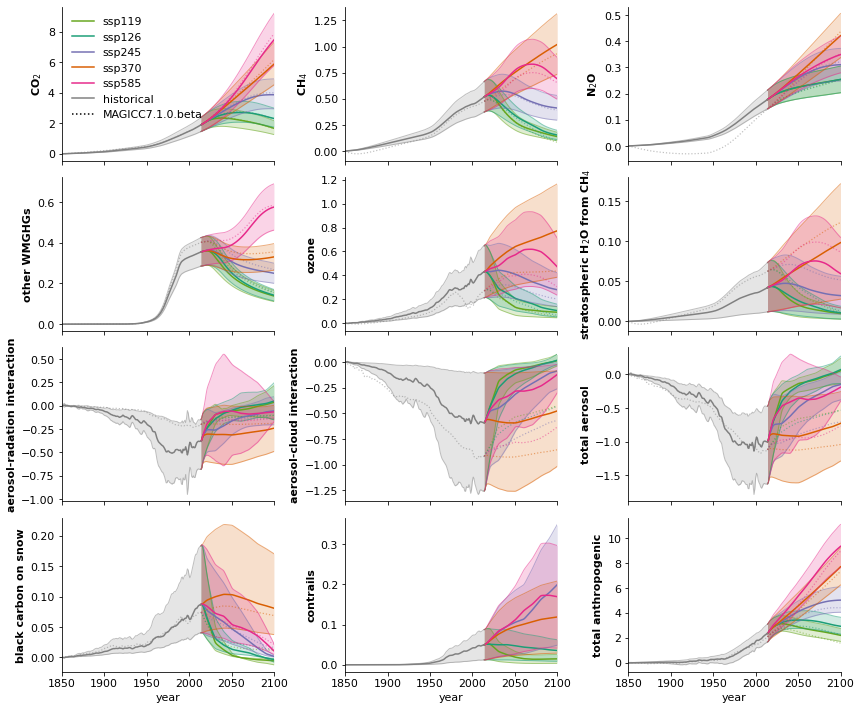

In [12]:
fig,ax = plt.subplots(4,3,figsize=(12,10))

colors= {'ssp245':'#7570b3','ssp370':'#d95f02','ssp585':'#e7298a','ssp119':'#66a61e','ssp126':'#1b9e77','history':'grey'}
map_forc_names = dict(zip(plot_RF.columns.levels[1].tolist(),['total','aerosol-cloud interaction','total aerosol','total anthropogenic','aerosol-radation interaction','black carbon on snow','CO$_2$','contrails','CH$_4$','N$_2$O','other WMGHGs','ozone','stratospheric H$_2$O from CH$_4$']))
forc_order = ['carbon_dioxide','methane','nitrous_oxide','other_wmghgs','ozone','strat_h2o','ari','aci','aer','bc_on_snow','contrails','anthro']

for ssp in choose_ssps:
    for i,forc in enumerate(forc_order):
        ax.flatten()[i].plot(plot_RF.loc[2014:2100,(ssp,forc,0.5)],color=colors[ssp],label=ssp)
        ax.flatten()[i].fill_between(np.arange(2014,2101),*plot_RF.loc[2014:2100,(ssp,forc,[0.05,0.95])].values.T,color=colors[ssp],alpha=0.2,lw=0)
        ax.flatten()[i].plot(np.arange(2014,2101),plot_RF.loc[2014:2100,(ssp,forc,[0.05,0.95])].values,color=colors[ssp],alpha=0.5,lw=1)
        
        ax.flatten()[i].plot(MAGICC_rf.loc[2014:2100,(ssp,forc)],color=colors[ssp],ls=':',lw=1.2,alpha=0.5)
        
        
for i,forc in enumerate(forc_order):
    ax.flatten()[i].plot(plot_RF.loc[1850:2014,('ssp245',forc,0.5)],color=colors['history'],label='historical')
    ax.flatten()[i].fill_between(np.arange(1850,2015),*plot_RF.loc[1850:2014,('ssp245',forc,[0.05,0.95])].values.T,color=colors['history'],alpha=0.2,lw=0)
    ax.flatten()[i].plot(np.arange(1850,2015),plot_RF.loc[1850:2014,('ssp245',forc,[0.05,0.95])].values,color=colors['history'],alpha=0.5,lw=1)
    
    ax.flatten()[i].plot(MAGICC_rf.loc[1850:2014,('ssp245',forc)],color=colors['history'],ls=':',lw=1.2,alpha=0.5)
    
    ax.flatten()[i].set_xlim(1850,2100)
    sn.despine()
    ax.flatten()[i].set_ylabel(map_forc_names[forc],fontweight='bold')
    
[a.set_xticklabels([]) for a in ax[:-1].flatten()]
[a.set_xlabel('year') for a in ax[-1]]
[a.ticklabel_format(style='plain') for a in ax[-1]]
ax[0,0].plot([],[],'k:',label='MAGICC7.1.0.beta')
ax[0,0].legend()
plt.tight_layout()

[fig.savefig('../../docs/manuscript/figures/Fig9.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

### Temp plot

''

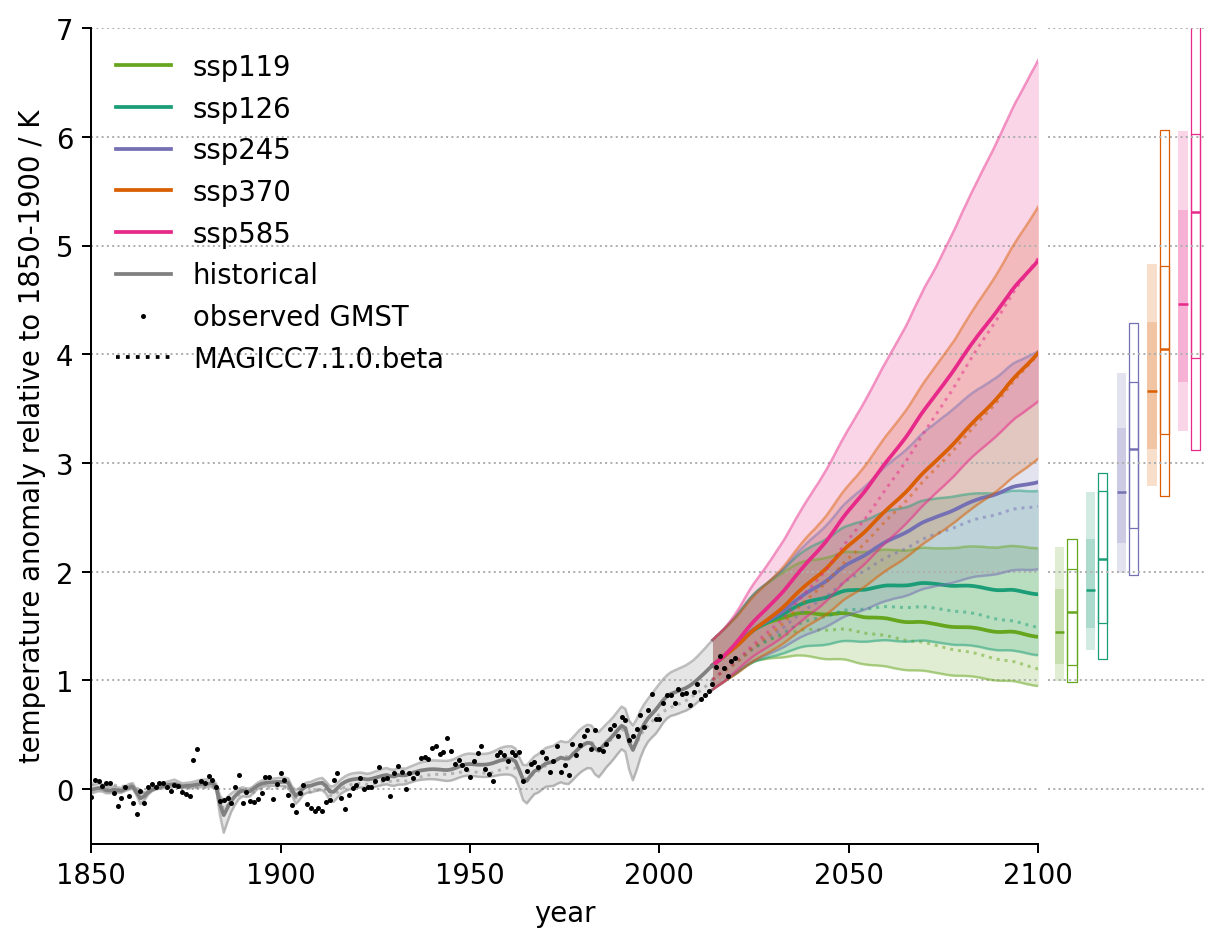

In [13]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1, 20,wspace=0.2)

## timeseries plot
ax = fig.add_subplot(gs[0,:-3])

for ssp in choose_ssps:
    ax.plot(plot_T.loc[2014:2100,(ssp,0.5)],color=colors[ssp],label=ssp)
    ax.fill_between(np.arange(2014,2101),*plot_T.loc[2014:2100,(ssp,[0.05,0.95])].values.T,color=colors[ssp],alpha=0.2,lw=0)
    ax.plot(np.arange(2014,2101),plot_T.loc[2014:2100,(ssp,[0.05,0.95])].values,color=colors[ssp],alpha=0.5,lw=1)
    
    ax.plot(MAGICC_T.loc[2014:2100,(ssp)],color=colors[ssp],ls=':',lw=1.2,alpha=0.5)
        
ax.plot(plot_T.loc[1850:2014,('ssp245',0.5)],color=colors['history'],label='historical')
ax.fill_between(np.arange(1850,2015),*plot_T.loc[1850:2014,('ssp245',[0.05,0.95])].values.T,color=colors['history'],alpha=0.2,lw=0)
ax.plot(np.arange(1850,2015),plot_T.loc[1850:2014,('ssp245',[0.05,0.95])].values,color=colors['history'],alpha=0.5,lw=1)    

ax.plot(MAGICC_T.loc[1850:2014,('ssp245')],color=colors['history'],ls=':',lw=1.2,alpha=0.5)

ax.plot(np.arange(1850,2021),(GMST_sets-GMST_sets.loc['1850':'1900'].mean()).mean(axis=1).values,'.k',ms=2,label='observed GMST')
ax.plot([],[],'k:',label='MAGICC7.1.0.beta')

# ax formatting
ax.set_xlim(1850,2100)
ax.legend(loc='upper left')
ax.set_ylabel('temperature anomaly relative to 1850-1900 / K')
ax.set_xlabel('year')
ax.ticklabel_format(style="plain")
sn.despine(ax=ax)

## boxplot
ax1 = fig.add_subplot(gs[0,-3:])
box_width = 0.3
for i,ssp in enumerate(choose_ssps):
    ax1.fill_betweenx(plot_T_EoC.loc[[0.05,0.95],ssp],i,i+box_width,color=colors[ssp],alpha=0.2,lw=0)
    ax1.fill_betweenx(plot_T_EoC.loc[[0.166,0.833],ssp],i,i+box_width,color=colors[ssp],alpha=0.2,lw=0)
    ax1.fill_betweenx([plot_T_EoC.loc[0.5,ssp]]*2,i,i+box_width,color=colors[ssp])
    
    i+=0.4
    ax1.fill_betweenx([CMIP6_ssp_data_by_model.loc[2081:2100].mean().xs(ssp,level=1).min(),CMIP6_ssp_data_by_model.loc[2081:2100].mean().xs(ssp,level=1).max()],i,i+box_width,fc=(0,0,0,0),ec=colors[ssp],lw=0.5)
    ax1.fill_betweenx(CMIP6_ssp_data_by_model.loc[2081:2100].mean().xs(ssp,level=1).quantile([0.166,0.833]),i,i+box_width,fc=(0,0,0,0),ec=colors[ssp],lw=0.5)
    ax1.fill_betweenx([CMIP6_ssp_data_by_model.loc[2081:2100].mean().xs(ssp,level=1).quantile(0.5)]*2,i,i+box_width,color=colors[ssp])
    
# ax1 formatting
sn.despine(ax=ax1,left=True,bottom=True)
ax1.yaxis.set_ticklabels([])
ax1.yaxis.set_ticks_position('none')
ax1.set_xticks([])

# both axes formatting
[a.set_ylim(-0.5,7) for a in [ax,ax1]]
[a.yaxis.grid(ls=':') for a in [ax,ax1]]

[fig.savefig('../../docs/manuscript/figures/Fig10.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
fig.dpi=180
''

number of CMIP6 models in each SSP projection & other experiments:

In [14]:
## get other experiments:
DECK_experiment_data = xr.open_dataset('../../aux/input-data/CMIP6/CMIP6_tuning_data.nc')

In [15]:
def format_table(x):
    if np.isnan(x):
        return ''
    else:
        return "{:.0f}".format(x)

DECK_table = DECK_experiment_data.tas.sel(time='1850').squeeze().stack(index=['climate_model','scenario','member_id']).to_pandas().groupby(level=[0,1]).count().unstack()
DECK_table.index.name='model'
DECK_table.columns.name='experiment'
    
SSP_table = CMIP6_ssp_data.loc[2081:2100].mean().dropna().groupby(level=[2,3]).count().unstack().replace(np.nan,0).astype(int)
SSP_table.index.name='model'
SSP_table.columns.name='experiment'

CMIP6_member_table = pd.concat([DECK_table,SSP_table],axis=1).replace(np.nan,0).astype(int)
CMIP6_member_table.index.name='model'
CMIP6_member_table.loc['Total models'] = (CMIP6_member_table>0).sum()

CMIP6_member_table#.to_latex('../../docs/manuscript/tables/TabS4',escape=False,bold_rows=True)

experiment,1pctCO2,abrupt-0p5xCO2,abrupt-2xCO2,abrupt-4xCO2,ssp119,ssp126,ssp245,ssp370,ssp460,ssp585
model,,,,,,,,,,
ACCESS-CM2,1,0,0,1,0,3,3,3,0,3
ACCESS-ESM1-5,1,0,0,1,0,3,3,3,0,3
AWI-CM-1-1-MR,1,0,0,1,0,1,1,5,0,1
BCC-CSM2-MR,1,0,0,1,0,1,1,1,0,1
BCC-ESM1,1,0,0,1,0,0,0,0,0,0
CAMS-CSM1-0,2,0,0,2,2,2,2,2,0,2
CESM2,1,1,1,0,0,3,6,3,0,5
CESM2-FV2,1,0,0,1,0,0,0,0,0,0
CESM2-WACCM,1,0,0,1,0,1,5,1,0,5


## Appendix I. GMST vs GSAT (linear trend)
Very brief section to compare our definition of global warming used in the CONSTRAINED ensemble (GMST average of 6 datasets) to GSAT estimated using the ERA5 reanalysis.

In [16]:
ERA5 = xr.open_dataset('../../aux/input-data/Temperature-observations/ERA5-glob-1979-to-2020.nc',chunks={'time':10})
ERA5 = ERA5.weighted(np.cos(np.deg2rad(ERA5.latitude))).mean(['longitude','latitude']).t2m.to_pandas()
ERA5 = ERA5.mean(axis=1).resample('y').mean()

In [17]:
GMST_scaling = GMST_sets.apply(lambda x: sp.stats.linregress(ERA5.loc['1979':'2020'].values,x.loc['1979':'2020'].values).slope)
print('mean GMST scaling:',GMST_scaling.mean())

mean GMST scaling: 0.9366326743575945


In [18]:
GMST_scaling

HadCRUT5    0.976738
HadCRUT4    0.865059
NOAA        0.894352
GISTEMP     0.971735
CW          0.949244
Berkeley    0.962666
dtype: float64

In [19]:
## bootstrap error (moving block methodology):
y = GMST_sets.HadCRUT5.loc['1979':'2020'].values
x = ERA5.loc['1979':'2020'].values

def autocorr(x):
    result = np.correlate(x,x,mode='full')
    return result[result.size//2:]

## we use blocks of length 6 & 7 (chosen @ random):
N=10000
result = np.empty(N)
for n in np.arange(N):
    
    blocklength = np.random.choice([6,7])
    n_blocks = 42//blocklength
    choose_blocks = np.random.choice(np.arange(42-blocklength),n_blocks)
    
    x = np.concatenate([ERA5.loc['1979':'2020'].values[x:x+blocklength] for x in choose_blocks])
    
    result[n] = np.mean([sp.stats.linregress(x,np.concatenate([GMST_sets.loc['1979':'2020',y].values[x:x+blocklength] for x in choose_blocks])).slope for y in GMST_sets.columns])

In [20]:
pd.Series(1-result).describe(percentiles=[0.05,0.5,0.95])

count    10000.000000
mean         0.049148
std          0.032927
min         -0.051944
5%           0.003768
50%          0.046056
95%          0.109954
max          0.204260
dtype: float64